# Лабораторная работа 6. Байесовский вывод для линейной регрессии
### Кирилл Захаров
2023

In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from scipy.stats import multivariate_normal
import scipy.stats as sts

plt.style.use('ggplot')

In [3]:
data = pd.read_csv('housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
data = pd.concat([data, pd.get_dummies(data['ocean_proximity']).astype(int)], axis=1)
data = data.drop(['ocean_proximity'], axis=1)

In [5]:
data = data.dropna()

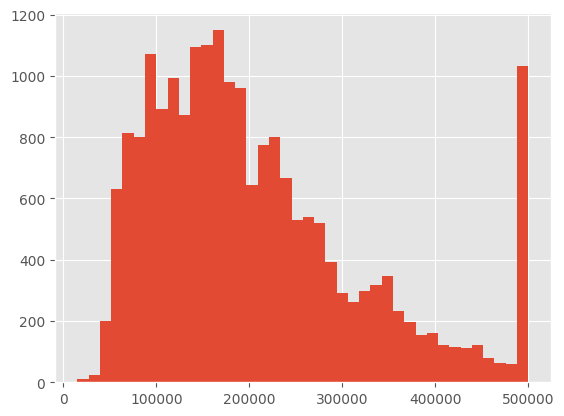

In [6]:
plt.hist(data['median_house_value'], bins=40)
plt.show()

In [7]:
data = data[data['median_house_value'] < np.quantile(data['median_house_value'], 0.9)]

Построим графики совместного распределения некоторых признаков. Будет считаться примерно 1 минуту.

/var/folders/31/d4jscthx2pn2pzww22f7p67r0000gn/T/ipykernel_62489/1819225802.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.5)


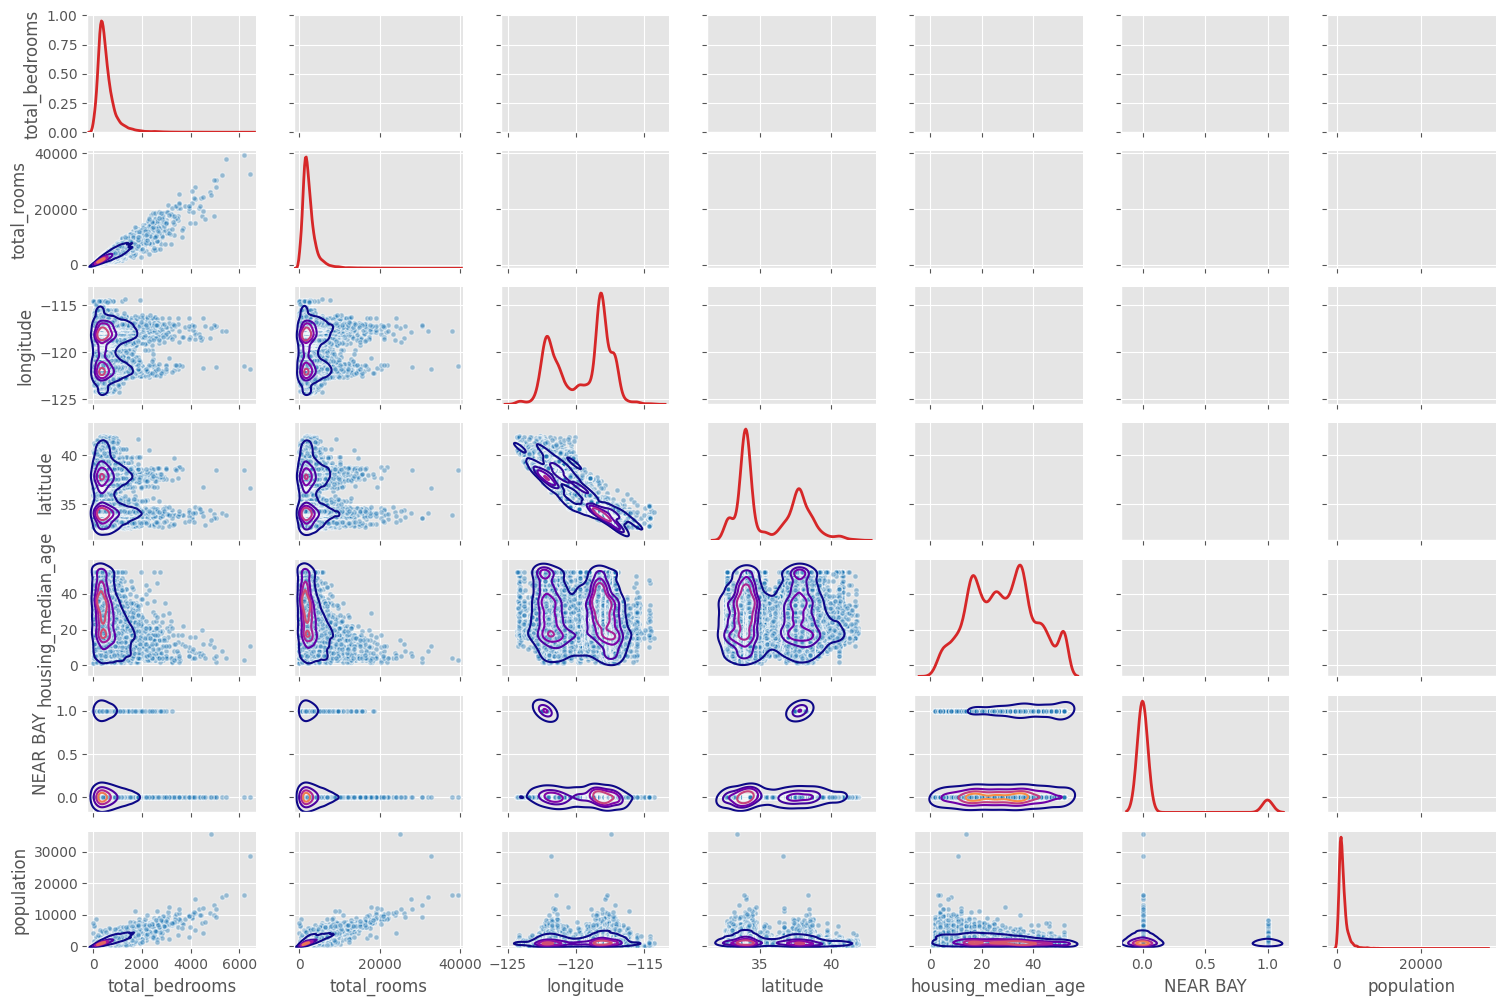

In [290]:
def snsPairGrid(df):
    g = sns.PairGrid(df, diag_sharey=False)
    g.fig.set_size_inches(15,10)
    
    g.map_diag(sns.kdeplot, lw=2, color='tab:red')
    g.map_lower(sns.scatterplot, s=15, color="tab:blue", linewidth=1, alpha=0.4)
    g.map_lower(sns.kdeplot, cmap='plasma', n_levels=5)
    plt.tight_layout(pad=0.5)
    

snsPairGrid(data[['total_bedrooms', 'total_rooms', 'longitude', 'latitude', 'housing_median_age', 'NEAR BAY', 'population']]) 

In [ ]:
data['diag'] = np.abs(data['longitude'] + data['latitude'])

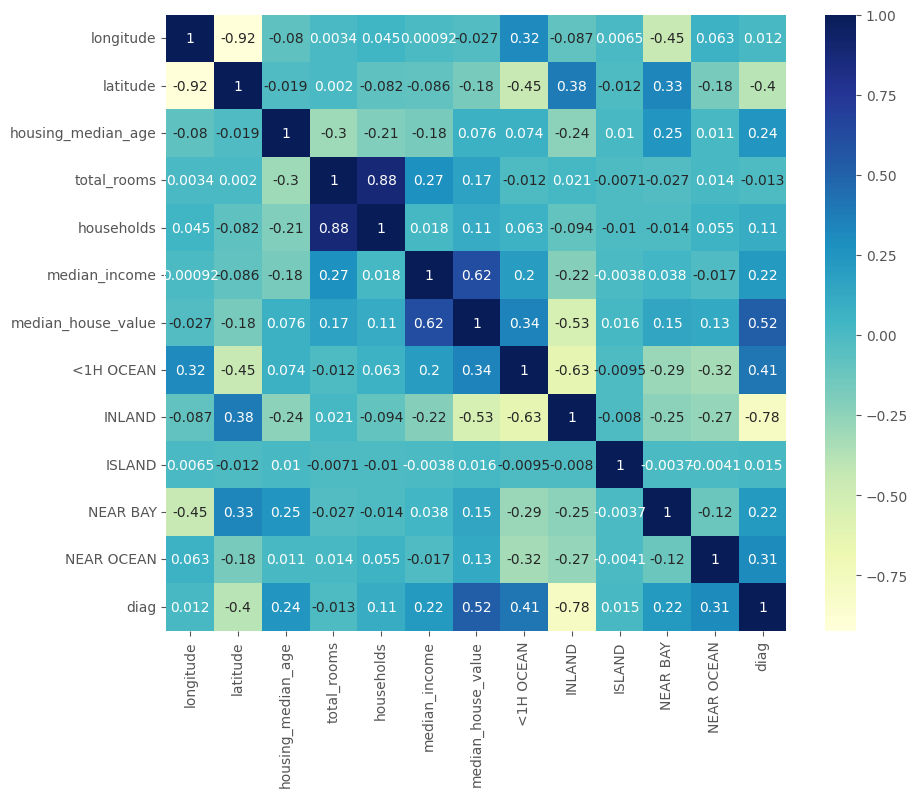

In [376]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='BuPu')

plt.show()

Уберем коррелируемые признаки.

In [291]:
data = data.drop(['total_bedrooms', 'population', 'longitude'], axis=1)

Уберем выбросы.

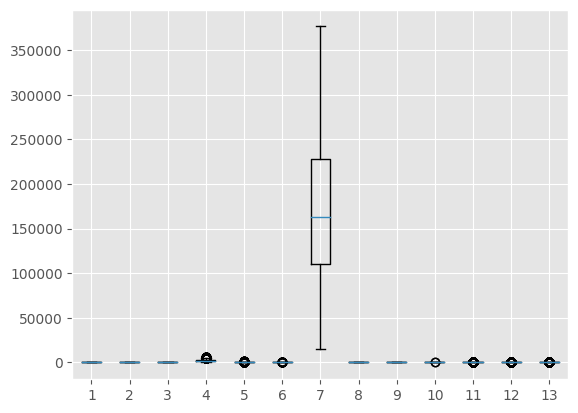

In [340]:
plt.boxplot(data)
plt.show()

In [330]:
data = data[data['total_rooms'] < np.quantile(data['total_rooms'], 0.75) + 1.5 * sts.iqr(data['total_rooms'])]
data = data[data['households'] < np.quantile(data['households'], 0.75) + 1.5 * sts.iqr(data['households'])]
data = data[data['median_income'] < np.quantile(data['median_income'], 0.75) + 1.5 * sts.iqr(data['median_income'])]

Создадим выборку для обучения и тестирования.

In [349]:
X = data[np.setdiff1d(data.columns.values, 'median_house_value')]

In [358]:
y = np.log1p(data['median_house_value'])

In [359]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

## Байесовский вывод. Часть 1

Для начала построим регрессию ElasticNet, которая включает в себе комбинацию $L_1$ и $L_2$ регуляризации. Данные регуляризации появляются для обычной регрессии, если вместо оценки максимального правдоподобия взять максимульную апостериорную оценку. Для этого нужно сделать байесовский вывод. От выбора априорного распределения будет зависить какой регуляризатор получится, например, если взять гауссовское, то возникнит $L_2$ ругуляризация, а если взять в качестве априорного лапласиан, то получится $L_1$ регуляризатор.

Возьмем в качестве априорного распределения для параметров модели гауссиан $p(w)=\mathcal{N}(w|0,\sigma_0^2 I)=\frac{1}{\sqrt{(2\pi \sigma_0^2)^d}}e^{-\frac{1}{2\sigma_0^2}w^Tw}$. Напишем логарифм апостериорного распределения $$\log p(w,D)=const + \log p(D|w)+\log p(w)=const - \frac{1}{2\sigma^2}\bigg(\sum_{i=1}^N(y_i-w^Tx_i)^2+\frac{\sigma^2}{\sigma_0^2}w^Tw \bigg)$$

Из этой формулы мы и получаем регуляризатор, выбрав гауссиан в качестве априорного получили $L_2$ регуляризатор.

Сделаем подбор параметра соотношения $L_1$ и $L_2$ регуляризатора.

In [360]:
params = {'l1_ratio': np.linspace(0.001, 0.999, 10)}

gscv = GridSearchCV(ElasticNet(), param_grid=params)

In [361]:
gscv.fit(X_train, y_train)

GridSearchCV(estimator=ElasticNet(),
             param_grid={'l1_ratio': array([0.001     , 0.11188889, 0.22277778, 0.33366667, 0.44455556,
       0.55544444, 0.66633333, 0.77722222, 0.88811111, 0.999     ])})

In [362]:
# lr = ElasticNet(l1_ratio=0.5, alpha=0.1)
lr = gscv.best_estimator_

lr.fit(X_train, y_train)

ElasticNet(l1_ratio=0.001)

In [363]:
mean_absolute_percentage_error(y_test, lr.predict(X_test))

0.02270731748861736

In [364]:
r2_score(y_test, lr.predict(X_test))

0.5350801875479323

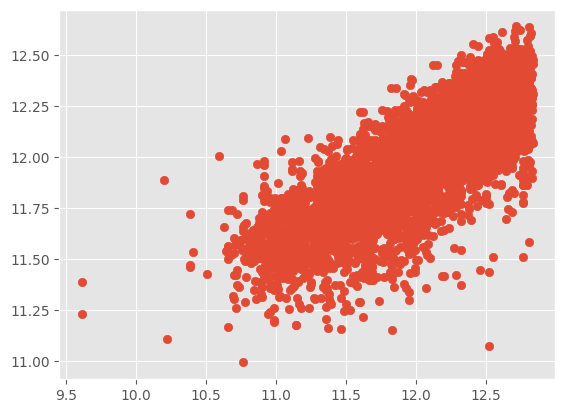

In [365]:
plt.scatter(y_test, lr.predict(X_test))
plt.show()

## Байесовский вывод. Часть 2

Продолжим байесовский вывод и получим не только максимальную апостериорную оценку, а найдем само апостериорное распределение параметров модели $\mathcal{N}(w|D,\mu,\Sigma)$, $D$ - набор данных. В качестве сопряженного априорного распределения $\mathcal{N}(w|\mu_0,\Sigma_0)$ возьмем гауссиан с параметрами $\mu_0,\Sigma_0$. Добавим 1 для константы. Правдоподобие у нас это гауссиан $\mathcal{N}(D|w)$, так как мы рассматриваем классический вариант регрессии, где ошибки распределены нормально.

In [366]:
mu0, sigma0 = np.ones(len(X_train.columns.values) + 1), 2 * np.eye(len(X_train.columns.values) + 1)
X_train_b = np.hstack((np.ones((len(X_train), 1)), X_train))
X_test_b = np.hstack((np.ones((len(X_test), 1)), X_test))

А теперь обновляем параметры гауссиана апостериорного распределения $\mathcal{N}(w|D,\mu,\Sigma)$. После байесовского вывода получатся следующие формулы:
$$\mu = \Sigma \Sigma_0^{-1} \mu_0^T + \frac{1}{ \sigma^2 }X^Ty$$
$$\Sigma = (\Sigma_0^{-1} + \frac{1}{\sigma^2}X^TX)^{-1}$$

In [367]:
def bayesian_update(mu0, sigma0, x, y, noise_var):
    sigma = np.linalg.inv(np.linalg.inv(sigma0) + (1 / noise_var) * np.matmul(np.transpose(x), x))
    mu = np.matmul(sigma, np.matmul(np.linalg.inv(sigma0), np.transpose(mu0)) + (1 / noise_var) * np.matmul(np.transpose(x), y))
    return mu, sigma

def generate_weights(mu, sigma, n_samples=100):
    return np.random.multivariate_normal(mu, sigma, n_samples)

In [368]:
mu, sigma = bayesian_update(mu0, sigma0, X_train_b, y_train.values, 5)

Сэмплируем параметры модели из апостериорного распределения.

In [369]:
weights = generate_weights(mu, sigma)

In [370]:
pred_bayes = X_test_b @ np.mean(weights, axis=0)

In [371]:
mean_absolute_percentage_error(y_test, pred_bayes)

0.02002702607017041

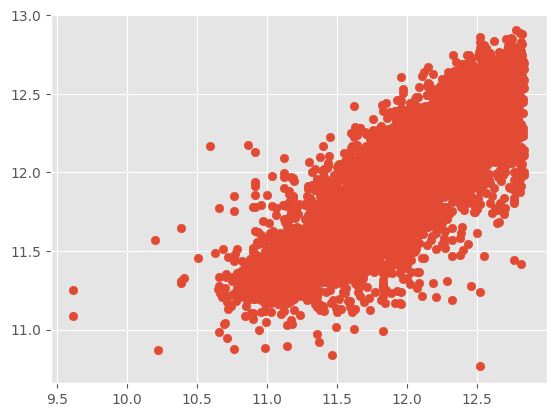

In [372]:
plt.scatter(y_test, pred_bayes)
plt.show()

### Одномерный пример с графиками плотности апостериорного распределения

Возьмем 100 точек $x$ от 0 до 5 и в качестве $y$ линейную зависимость с параметрами $w_0=13,w_1=5$. Сначала возьмем одну точку. Правдоподобие по одной точки не даст хорошего результата, но далее будем увеличивать.

In [204]:
data_x = np.linspace(0, 5, 100)
data_y = 5 * data_x + 13
data_x = np.vstack([np.ones(len(data_x)), data_x]).T

x = data_x[:1]
y = data_y[:1]

In [205]:
def plot_samples(weights, func):
    xs = np.linspace(0, 5, 100)
    plt.figure(figsize=(10, 5), dpi=100)
    
    
    for w in weights:
        plt.plot(xs, func(w, xs), lw=.3, color='tab:red')
        
    # plt.plot(data_x, data_y, label="Test values", lw=3)
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Sample lines')
    # plt.legend()
    plt.show()
    
def linear(weights, x):
    return weights[0] + weights[1] * x

In [206]:
mu0, sigma0 = np.ones(2), 2 * np.eye(2)
mu, sigma = bayesian_update(mu0, sigma0, x, y, 2)
weights = generate_weights(mu, sigma, 100)

Видно, что пока параметры приближаются не очень хорошо.

In [207]:
weights[:10]

array([[ 7.30807325, -1.66842053],
       [ 7.12257745,  2.37783926],
       [ 8.89801043,  0.2033255 ],
       [ 5.26669457, -0.13319725],
       [ 7.70146832,  1.7555527 ],
       [ 6.85827792, -1.33767162],
       [ 7.04660129,  1.43535074],
       [ 7.96770603, -1.13433595],
       [ 6.58139121, -0.40138122],
       [ 7.14217554,  1.87696389]])

Сэмплируем параметры из текущего апостериорного распределения и строим прямые с этими параметрами.

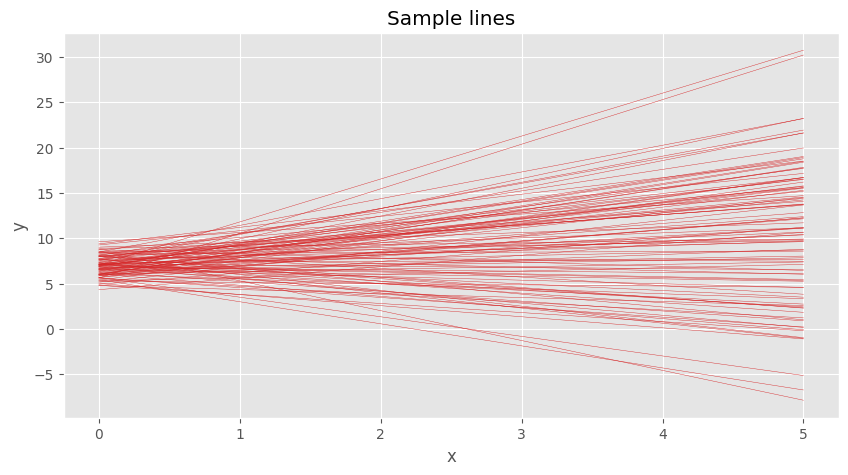

In [208]:
plot_samples(weights, linear)

In [237]:
def plot_posterior(X, Y, mu, sigma):
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    Z = multivariate_normal.pdf(pos, mean=mu, cov=sigma)
    plt.figure(figsize=(10, 5), dpi=100)
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    plt.title('Апостериорное распределение параметров модели')
    plt.xlabel('Смещение')
    plt.ylabel('Наклон')
    plt.show()

Получили гауссиан, как и ожидалось.

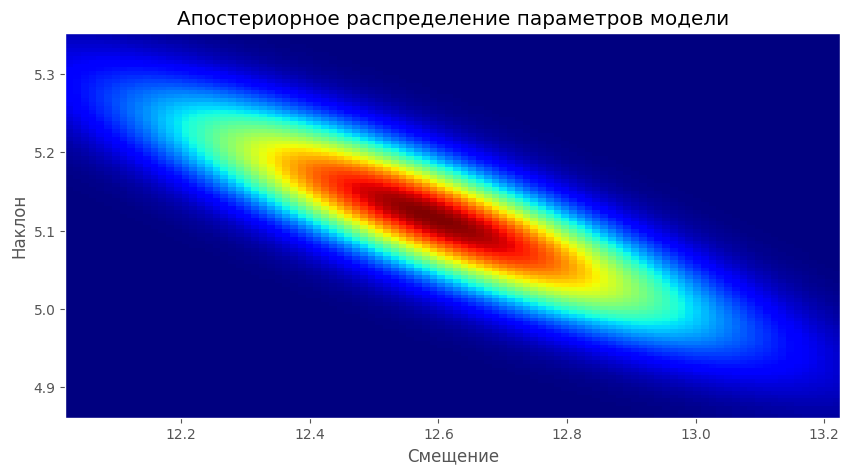

In [238]:
X = np.linspace(np.min(weights[:,0]), np.max(weights[:,0]), 100)
Y = np.linspace(np.min(weights[:,1]), np.max(weights[:,1]), 100)
X, Y = np.meshgrid(X, Y)

plot_posterior(X, Y, mu, sigma)

Увеличим число точек.

In [216]:
x = data_x[:3]
y = data_y[:3]

mu0, sigma0 = np.ones(2), 2 * np.eye(2)
mu, sigma = bayesian_update(mu0, sigma0, x, y, 2)
weights = generate_weights(mu, sigma, 100)

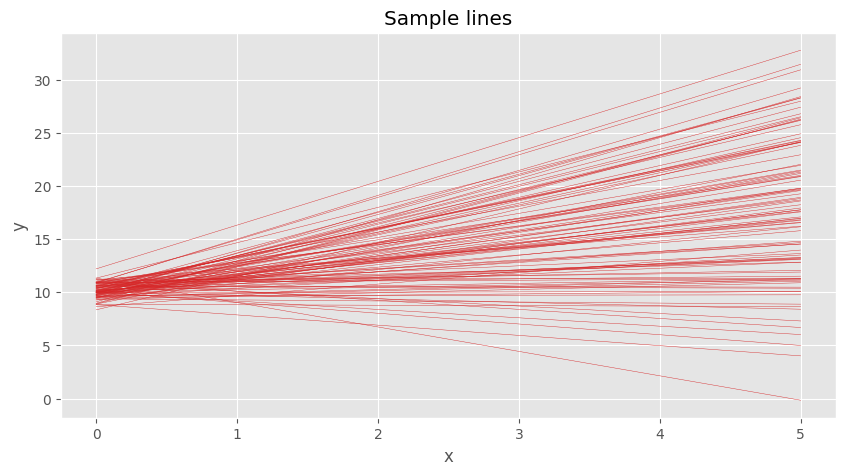

In [217]:
plot_samples(weights, linear)

Уже другой гауссиан, более точный.

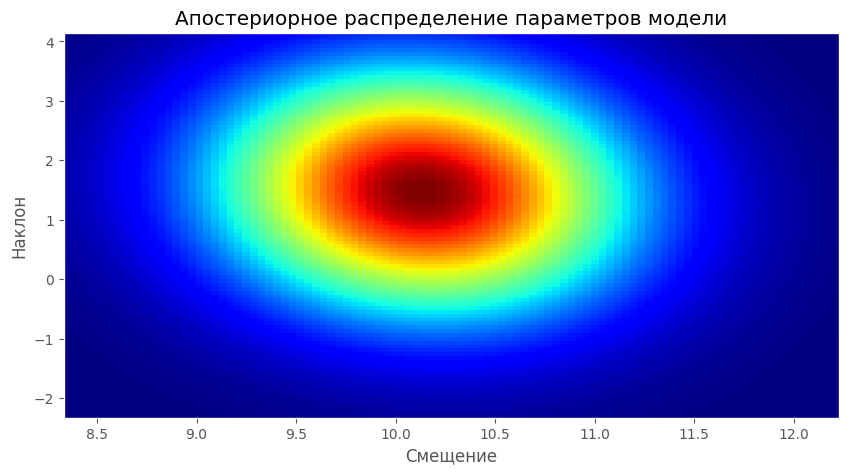

In [218]:
X = np.linspace(np.min(weights[:,0]), np.max(weights[:,0]), 100)
Y = np.linspace(np.min(weights[:,1]), np.max(weights[:,1]), 100)
X, Y = np.meshgrid(X, Y)

plot_posterior(X, Y, mu, sigma)

Наконец возьмем все точки.

In [219]:
x = data_x[:]
y = data_y[:]

mu0, sigma0 = np.ones(2), 2 * np.eye(2)
mu, sigma = bayesian_update(mu0, sigma0, x, y, 2)
weights = generate_weights(mu, sigma, 100)

После сэмплирования параметров из апостериорного получили близкие к нашим значениям параметров. Все прямые уже сходятся к исходной.

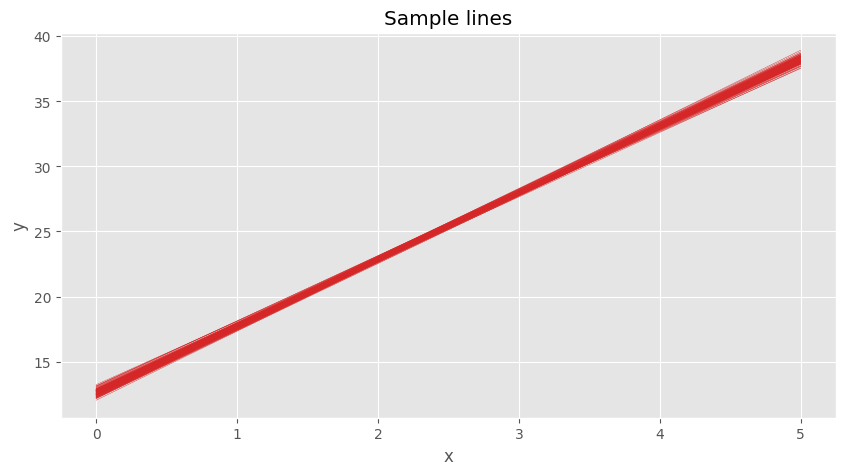

In [286]:
plot_samples(weights, linear)

Гауссиан принял нужную форму.

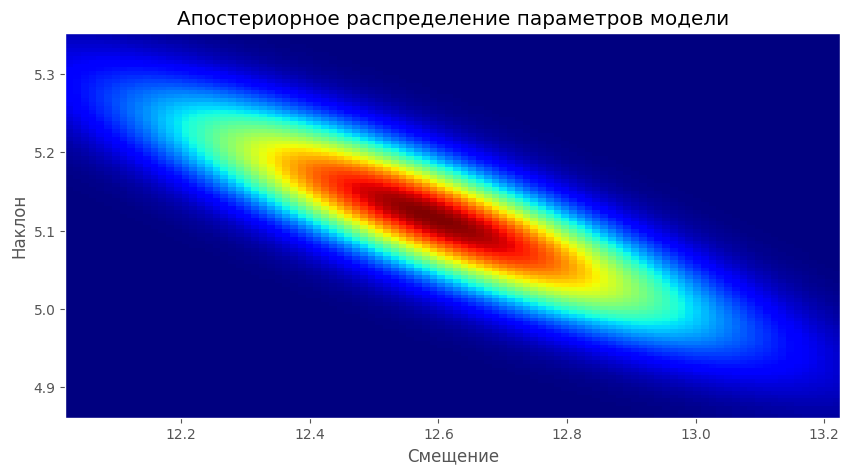

In [222]:
X = np.linspace(np.min(weights[:,0]), np.max(weights[:,0]), 100)
Y = np.linspace(np.min(weights[:,1]), np.max(weights[:,1]), 100)
X, Y = np.meshgrid(X, Y)

plot_posterior(X, Y, mu, sigma)